In [308]:
# Import libraries
import pandas as pd
import numpy as np
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

from matplotlib import pyplot
from matplotlib.pyplot import figure

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pca import pca

from dash import Dash, dcc, html, Input, Output, callback
import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from ipywidgets import interact, interact_manual

import warnings
warnings.filterwarnings('ignore') # Suppress warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)

In [123]:
f = open('data/Dairy_aggregate.xlsx', 'rb').read()
dairy_ag_df = pd.read_excel(f)

# Dataset 2 PCA/Clustering

In [124]:
dairy_ag_df.dtypes

Year                                                              int64
Member State                                                     object
8 Types of Farming                                               object
14 Types of Farming                                              object
(SE005) Economic size (€'000)                                    object
                                                                 ...   
(SE705) Processing of animals and animals' products (€/farm)     object
(SE710) Processing of crops (€/farm)                             object
(SE730) Other OGA output (€/farm)                                object
(SYS02) Farms represented (nb)                                  float64
(SYS03) Sample farms                                             object
Length: 183, dtype: object

In [125]:
def replace_missing_str(df):
    for column in df.columns.tolist():
        df[column] = df[column].apply(lambda value: value.replace('-', '---') if value == '-' else value)
        df[column] = df[column].replace('---', np.nan)
        try:
            if df[column].dtype == 'object':
                df[column] = df[column].astype(float)
        except Exception as e:
            print(e)

replace_missing_str(dairy_ag_df)
dairy_ag_df.dtypes

dairy_ag_df['Year'] = dairy_ag_df['Year'].astype(int)

could not convert string to float: 'EU-28'
could not convert string to float: '(5) Milk'
could not convert string to float: '(45) Specialist milk'
could not convert string to float: '10000 - <20000'


Year                                                              int64
Member State                                                     object
8 Types of Farming                                               object
14 Types of Farming                                              object
(SE005) Economic size (€'000)                                   float64
                                                                 ...   
(SE705) Processing of animals and animals' products (€/farm)    float64
(SE710) Processing of crops (€/farm)                            float64
(SE730) Other OGA output (€/farm)                               float64
(SYS02) Farms represented (nb)                                  float64
(SYS03) Sample farms                                             object
Length: 183, dtype: object

In [126]:
dairy_ag_df.describe()

,Year,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE035) Cereals (ha),(SE041) Other field crops (ha),(SE042) Energy crops (ha),(SE046) Vegetables and flowers (ha),(SE050) Vineyards (ha),(SE054) Permanent crops (ha),(SE055) Orchards (ha),(SE060) Olive groves (ha),(SE065) Other permanent crops (ha),(SE071) Forage crops (ha),(SE072) Agricultural fallows (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE075) Woodland area (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE090) Other cattle (LU),(SE095) Sheep and goats (LU),(SE100) Pigs (LU),(SE105) Poultry (LU),(SE110) Yield of wheat (q/ha),(SE115) Yield of maize (q/ha),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE135) Total output crops & crop production (€/farm),(SE136) Total crops output (€/ha),(SE140) Cereals (€/farm),(SE145) Protein crops (€/farm),(SE146) Energy crops (€),(SE150) Potatoes (€/farm),(SE155) Sugar beet (€/farm),(SE160) Oil-seed crops (€/farm),(SE165) Industrial crops (€/farm),(SE170) Vegetables & flowers (€/farm),(SE175) Fruit (excl. Citrus and grapes) (€/farm),(SE180) Citrus fruit (€/farm),(SE185) Wine and grapes (€/farm),(SE190) Olives & olive oil (€/farm),(SE195) Forage crops (€/farm),(SE200) Other crop output (€/farm),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE220) Beef and veal (€/farm),(SE225) Pigmeat (€/farm),(SE022) Share of OGA work /AWU (%),(SE230) Sheep and goats (€/farm),(SE235) Poultrymeat (€/farm),(SE240) Eggs (€/farm),(SE245) Ewes' and goats' milk (€/farm),(SE251) Other livestock & products (€/farm),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE284) Specific crop costs (€/ha),(SE285) Seeds and plants (€),(SE290) Seeds and plants home-grown (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE300) Crop protection (€),(SE305) Other crop specific costs (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE320) Feed for pigs & poultry (€),(SE325) Feed for pigs&poultry home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE331) Forestry specific costs (€),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)

In [127]:
# Doing it this way so I can add more columns later and this will skip the columns that were already dropped.

dairy_ag_df = dairy_ag_df[[
        'Year',
        'Member State',
        "(SE005) Economic size (€'000)",
        '(SE010) Total labour input (AWU)',
        '(SE011) Labour input (hrs)',
        '(SE015) Unpaid labour input (AWU)',
        '(SE016) Unpaid labour input (hrs)',
        '(SE020) Paid labour input (AWU)',
        '(SE021) Paid labour Input (hrs)',
        '(SE025) Total Utilised Agricultural Area (ha)',
        '(SE028) Permanent grassland (ha)',
        '(SE030) Rented UAA (ha)',
        '(SE073) Set aside (ha)',
        '(SE074) Total agricultural area out of production (ha)',
        '(SE080) Total livestock units (LU)',
        '(SE085) Dairy cows (LU)',
        '(SE086) Cattle dairy cows (LU)',
        '(SE087) Buffalo dairy cows (LU)',
        '(SE120) Stocking density (LU/ha)',
        '(SE125) Milk yield (kg/cow)',
        '(SE126) Milk yield cattle dairy cows (kg/cow)',
        '(SE127) Milk yield buffalo dairy cows (kg/cow)',
        '(SE131) Total output (€/farm)',
        '(SE132) Total output / Total input (ratio)',
        '(SE206) Total output livestock & livestock products (€/farm)',
        '(SE207) Total livestock output (€/LU)',
        '(SE211) Change in value of livestock (€)',
        "(SE216) Cows' milk & milk products (€/farm)",
        '(SE022) Share of OGA work /AWU (%)',
        '(SE256) Other output (€/farm)',
        '(SE260) Farmhouse consumption (€)',
        '(SE265) Farm use (€)',
        '(SE270) Total Inputs (€)',
        '(SE275) Total intermediate consumption (€)',
        '(SE281) Total specific costs (€)',
        '(SE295) Fertilisers (€)',
        '(SE296) Fertiliser N (q)',
        '(SE297) Fertiliser P2O5 (q)',
        '(SE298) Fertiliser K2O (q)',
        '(SE309) Specific livestock costs (€/LU)',
        '(SE310) Feed for grazing livestock (€)',
        '(SE315) Feed for grazing livestock home-grown (€)',
        '(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm)',
        '(SE336) Total farming overheads (€)',
        '(SE340) Machinery & building current costs (€)',
        '(SE345) Energy (€)',
        '(SE350) Contract work (€)',
        '(SE356) Other direct inputs (€)',
        '(SE360) Depreciation (€)',
        '(SE365) Total external factors (€)',
        '(SE370) Wages paid (€)',
        '(SE375) Rent paid (€)',
        '(SE380) Interest paid (€)',
        '(SE381) Balance of interest paid and received (€)',
        '(SE390) Taxes (€)',
        '(SE395) VAT balance excluding on investments (€)',
        '(SE405) Balance subsidies & taxes on investments (€)',
        '(SE406) Subsidies on investments (€)',
        '(SE407) Payments to dairy outgoers (€)',
        '(SE408) VAT balance on investments (€)',
        '(SE409) Subsidies on agricultural investments (€)',
        '(SE410) Gross Farm Income (€)',
        '(SE415) Farm Net Value Added (€)',
        '(SE420) Farm Net Income (€)',
        '(SE425) Farm Net Value Added (€/AWU)',
        '(SE430) Family Farm Income (€/FWU)',
        '(SE436) Total assets (€)',
        '(SE437) Total assets, opening valuation (€)',
        '(SE441) Total fixed assets (€)',
        '(SE446) Land, permanent crops & quotas (€)',
        '(SE450) Buildings (€)',
        '(SE455) Machinery and equipment (€)',
        '(SE460) Breeding livestock (€)',
        '(SE465) Total current assets (€)',
        '(SE470) Non-breeding livestock (€)',
        '(SE475) Stock of agricultural products (€)',
        '(SE476) Inventories (€)',
        '(SE480) Other circulating capital (€)',
        '(SE485) Total liabilities (€)',
        '(SE490) Long & medium-term loans (€)',
        '(SE495) Short-term loans (€)',
        '(SE501) Net worth (€)',
        '(SE506) Change in net worth (€)',
        '(SE510) Average farm capital (€)',
        '(SE516) Gross Investment on fixed assets (€)',
        '(SE521) Net Investment on fixed assets (€)',
        '(SE526) Cash Flow 1 (€)',
        '(SE530) Cash Flow 2 (€)',
        '(SE532) Cash flow / farm total capital (€)',
        '(SE600) Balance current subsidies & taxes (€)',
        '(SE605) Total subsidies - excluding on investments (€)',
        '(SE606) Total direct payments (€)',
        '(SE611) Compensatory payments/area payments (€)',
        '(SE612) Set aside premiums (€)',
        '(SE615) Total subsidies on livestock (€)',
        '(SE616) Subsidies dairying (€)',
        '(SE618) Subsidies sheep & goats (€)',
        '(SE621) Environmental subsidies (€)',
        '(SE622) LFA subsidies (€)',
        '(SE623) Other rural development payments (€)',
        '(SE624) Total support for rural development (€)',
        '(SE625) Subsidies on intermediate consumption (€)',
        '(SE626) Subsidies on external factors (€)',
        '(SE630) Decoupled payments (€)',
        '(SE631) Single Farm payment (€)',
        '(SE632) Single Area payment (€)',
        '(SE640) Additional aid (€)',
        '(SE650) Support_Art68 (€)',
        '(SE699) Other subsidies (€)',
        '(SE700) Total OGA output (€/farm)',
        '(SE720) Contractual work services (€)',
        '(SE725) Agritourism (€)',
        '(SE750) Total specific costs for OGA (€)',
        '(SE447) Agricultural land (€/farm)',
        '(SE462) Intangible assets (€/farm)',
        '(SE332) Veterinary expenses (€/farm)',
        '(SE765) Milk processing specific cost (€/farm)',
        "(SE766) Cows' milk processing specific cost (€/farm)",
        "(SE705) Processing of animals and animals' products (€/farm)",
        '(SE730) Other OGA output (€/farm)',
        '(SYS02) Farms represented (nb)',
            ]]

In [128]:
len(dairy_ag_df.columns.tolist())

121

In [129]:
# Standardise member state names across different datasets
dairy_ag_df = dairy_ag_df[(dairy_ag_df['Member State'] != 'EU27_2020') & (dairy_ag_df['Member State'] != 'EU-28') & (dairy_ag_df['Member State'] != '(UK) United Kingdom')]

dairy_ag_df['Member State'] = dairy_ag_df['Member State'].apply(lambda x: x[5:])

In [130]:
dairy_ag_df.shape

(492, 121)

In [131]:
dairy_ag_df[dairy_ag_df['Member State'] == '']['Year'].unique()
dairy_ag_df[dairy_ag_df['Member State'] == 'United Kingdom']['Year'].unique()
dairy_ag_df[(dairy_ag_df['Member State'] == 'Belgium')].Year.unique()

array([], dtype=int32)

array([], dtype=int32)

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [132]:
dairy_ag_df[(dairy_ag_df['Member State'] == 'Ireland') & (dairy_ag_df['Year'] == 2014)]

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE

In [133]:
dairy_ag_df['Member State'].unique()
dairy_ag_df['Member State'].unique().size

dairy_ag_df['Year'].unique()
dairy_ag_df['Year'].unique().size

# dairy_ag_df['(SE005) Economic size (€\'000)'].unique()
# dairy_ag_df['(SE005) Economic size (€\'000)'].unique().size

array(['Belgium', 'Czechia', 'Denmark', 'Germany', 'Estonia', 'Ireland',
       'Greece', 'Spain', 'France', 'Italy', 'Cyprus', 'Latvia',
       'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands',
       'Austria', 'Poland', 'Portugal', 'Slovenia', 'Slovakia', 'Finland',
       'Sweden', 'Bulgaria', 'Romania', 'Croatia'], dtype=object)

27

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

19

<Figure size 960x480 with 0 Axes>

<Axes: xlabel='Year', ylabel="(SE216) Cows' milk & milk products (€/farm)">

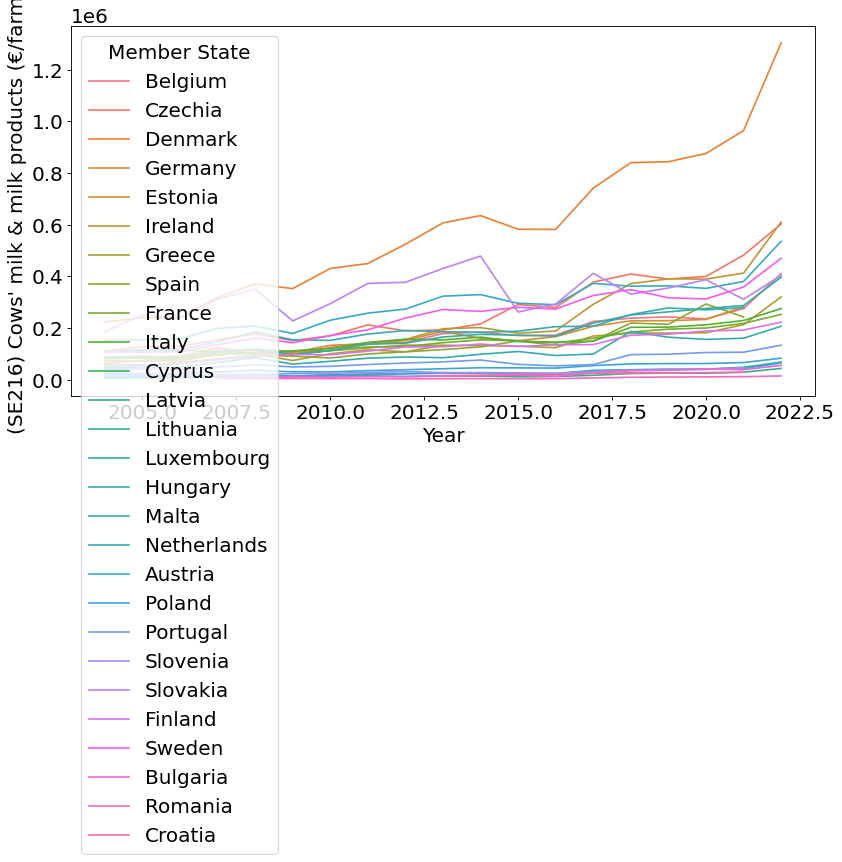

In [135]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x="Year", y="(SE216) Cows' milk & milk products (€/farm)", hue="Member State", data=dairy_ag_df)


In [136]:
app2 = Dash(__name__)

app2.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="column",
            options=dairy_ag_df.columns.tolist(),
            value="(SE085) Dairy cows (LU)",
        ),
        dcc.Dropdown(
            id="state_a",
            options=dairy_ag_df['Member State'].unique(),
            value="Ireland",
        ),
        dcc.Dropdown(
            id="state_b",
            options=dairy_ag_df['Member State'].unique(),
            value="Poland",
        ),
    ], style={'width': '40%', 'display': 'inline-block'}),
    dcc.Graph(id='graph-with-slider'),
])


@app2.callback(
    Output('graph-with-slider', 'figure'),
    Input('column', 'value'),
    Input('state_a', 'value'),
    Input('state_b', 'value'),
    )
def update_figure(column, state_a, state_b):
    filtered_df = dairy_ag_df[dairy_ag_df['Member State'].isin([state_a, state_b])]

    fig = px.line(filtered_df, x="Year", y=column, color='Member State')
    fig.update_layout(transition_duration=500)

    return fig

app2.run_server(debug=True, port=8055)

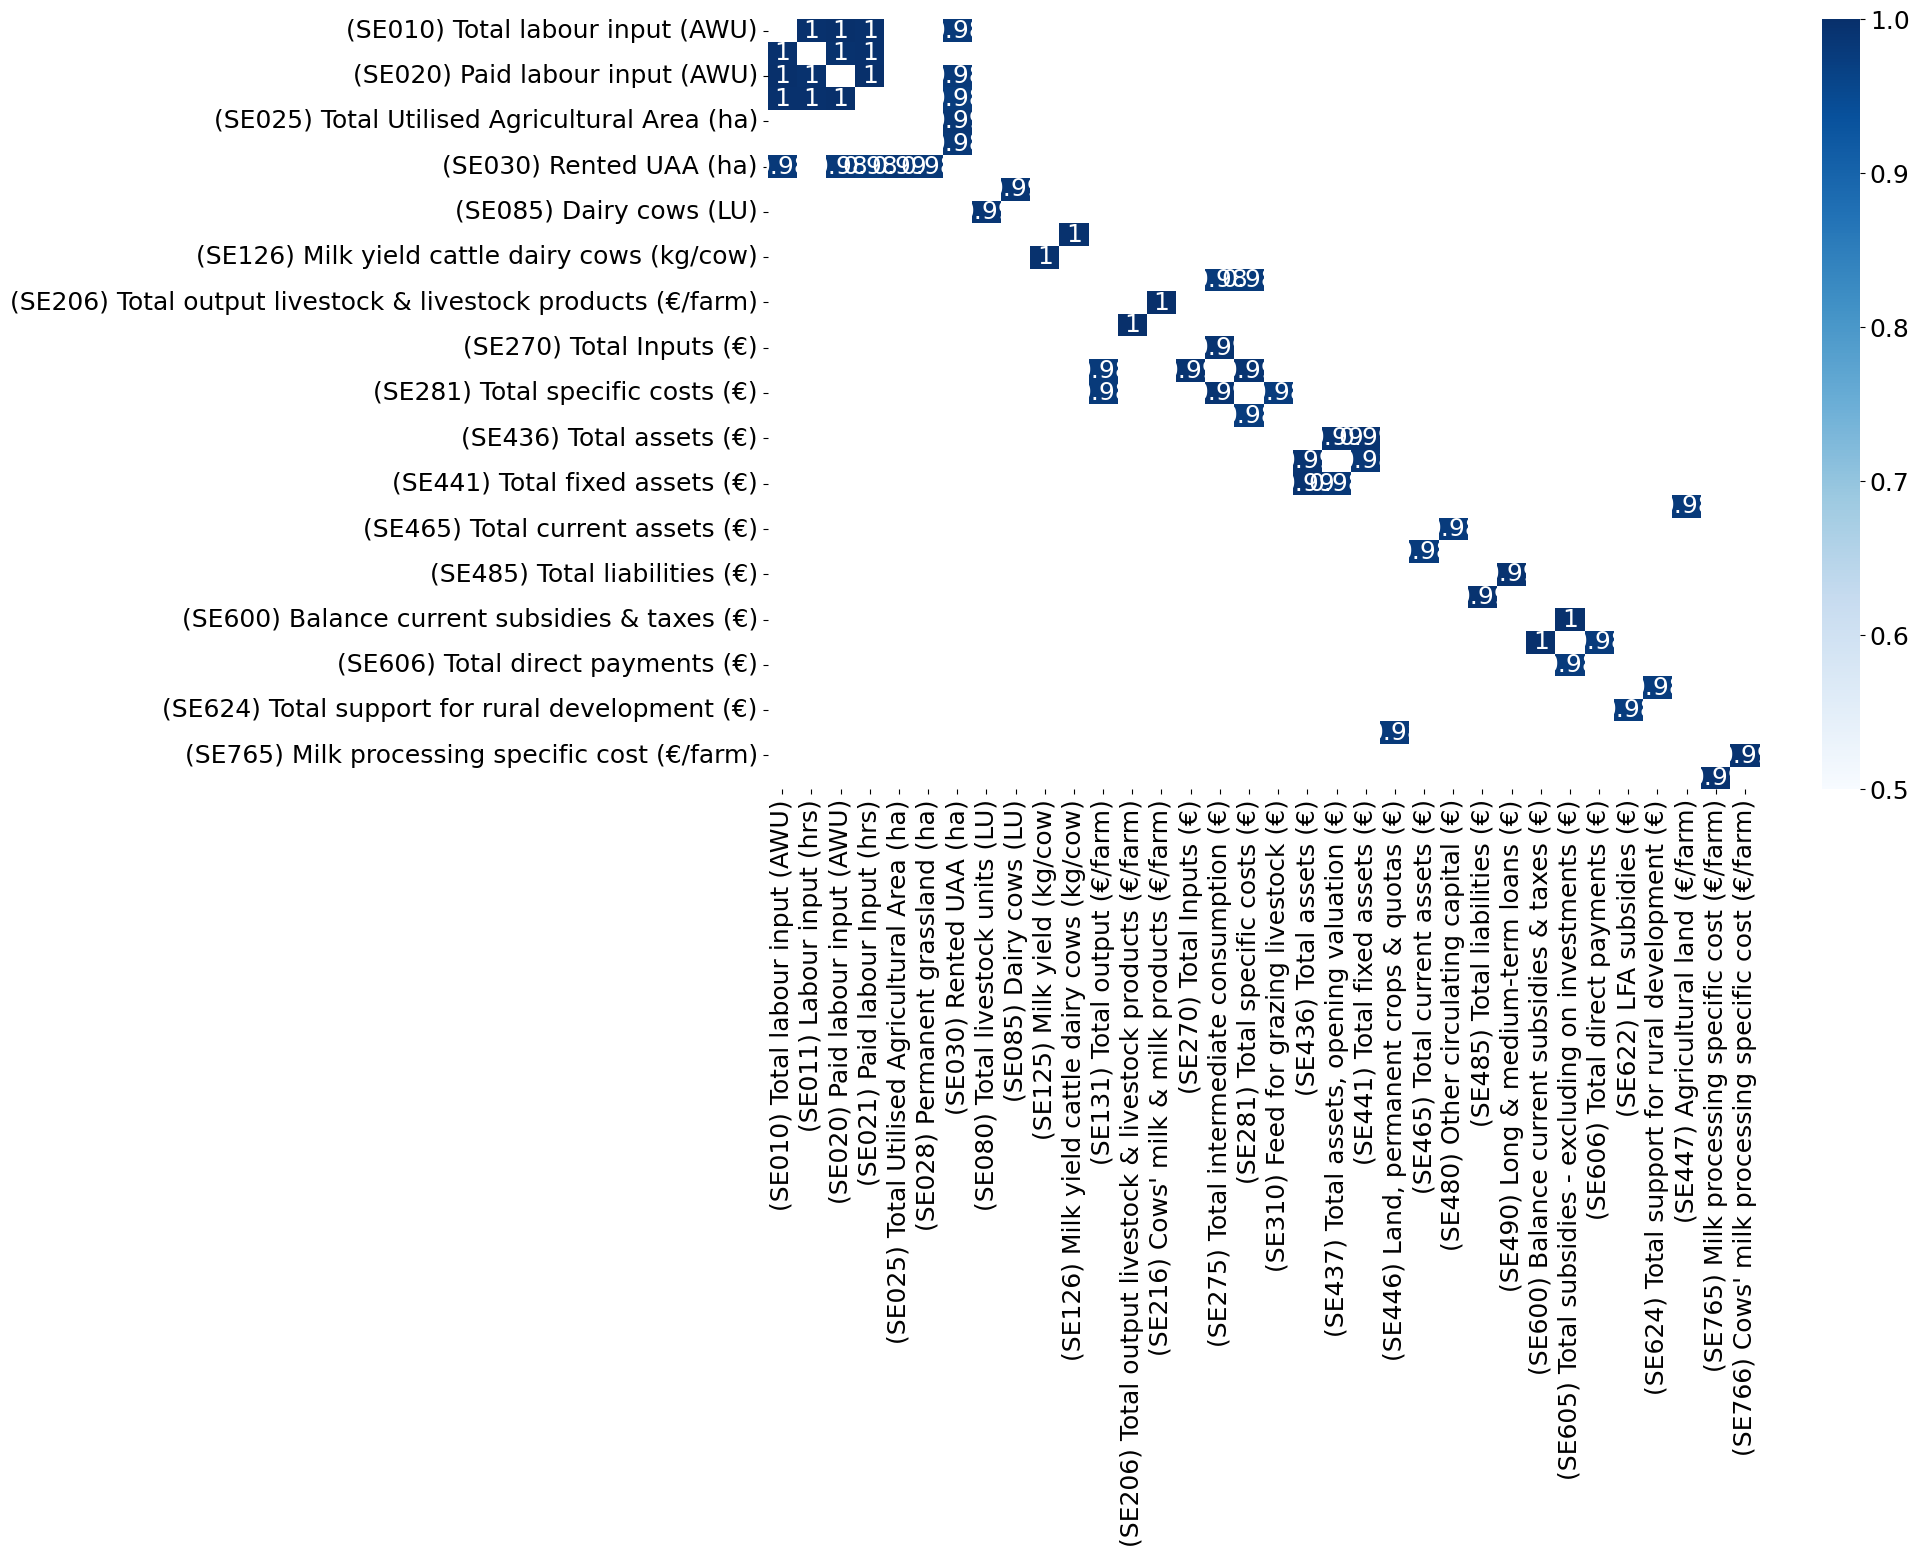

In [137]:
# Create a correlation matrix
corr_matrix = dairy_ag_df.select_dtypes(include=['float64', 'int64']).corr()

# Filter the matrix to only show correlations above 0.5
filtered_corr_matrix = corr_matrix[(corr_matrix >= 0.975) & (corr_matrix < 1)].dropna(how='all').dropna(axis=1, how='all')

# Plot the heatmap
fig, ax = pyplot.subplots(figsize=(16, 10))
sns.heatmap(filtered_corr_matrix, cmap="Blues", annot=True, vmin=0.5, vmax=1, ax=ax);

#### Data preparation: Imputing, Scaling, Encoding Y Labels

In [138]:
# Create an imputer object with a strategy of 'median'
imputer = SimpleImputer(strategy='median')

dairy_ag_df_imputed = dairy_ag_df.copy()

# Iterate over all NUMERIC columns in the dataframe
for column in dairy_ag_df.select_dtypes(include=['float64', 'int64']).columns:
    # Fit the imputer on the column
    dairy_ag_df_imputed[column]  = imputer.fit_transform(dairy_ag_df[[column]])


# Verify missing values
missing_values = dairy_ag_df_imputed.isna().sum()
# Print the number of missing values in each column
columns_with_missing_values = missing_values[missing_values > 0].index
print(columns_with_missing_values)

Index([], dtype='object')


In [139]:
Y_labels = dairy_ag_df_imputed['Member State']
X_features = dairy_ag_df_imputed.drop(columns=['Member State'])

In [140]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler and transform the features
X_features_scaled = scaler.fit_transform(X_features)

# The result is a numpy array, convert it back to a dataframe
X_features = pd.DataFrame(X_features_scaled, columns=X_features.columns)

In [141]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder and transform the labels
Y_labels_encoded = le.fit_transform(Y_labels)

# The result is a numpy array, convert it back to a pandas Series
Y_labels = pd.Series(Y_labels_encoded, name=Y_labels.name)

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!
# THIS IS WHERE THE BELOW IS COMING FROM

# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
# https://erdogant.github.io/pca/pages/html/Examples.html

### PCA

#### In order to determin the number of principal components....

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [120] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [28] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [120] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[28]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
      PC feature   loading  type
0    PC1      32  0.137670  best
1    PC2      64  0.198814  best
2    PC3     116  0.244515  best
3    PC4      55  0.350795  best
4    PC5     114  0.279129  best
..   ...     ...       ...   ...
122  PC2     113  0.184943  weak
123  PC3    

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 28 Principal Components explain [95.56%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

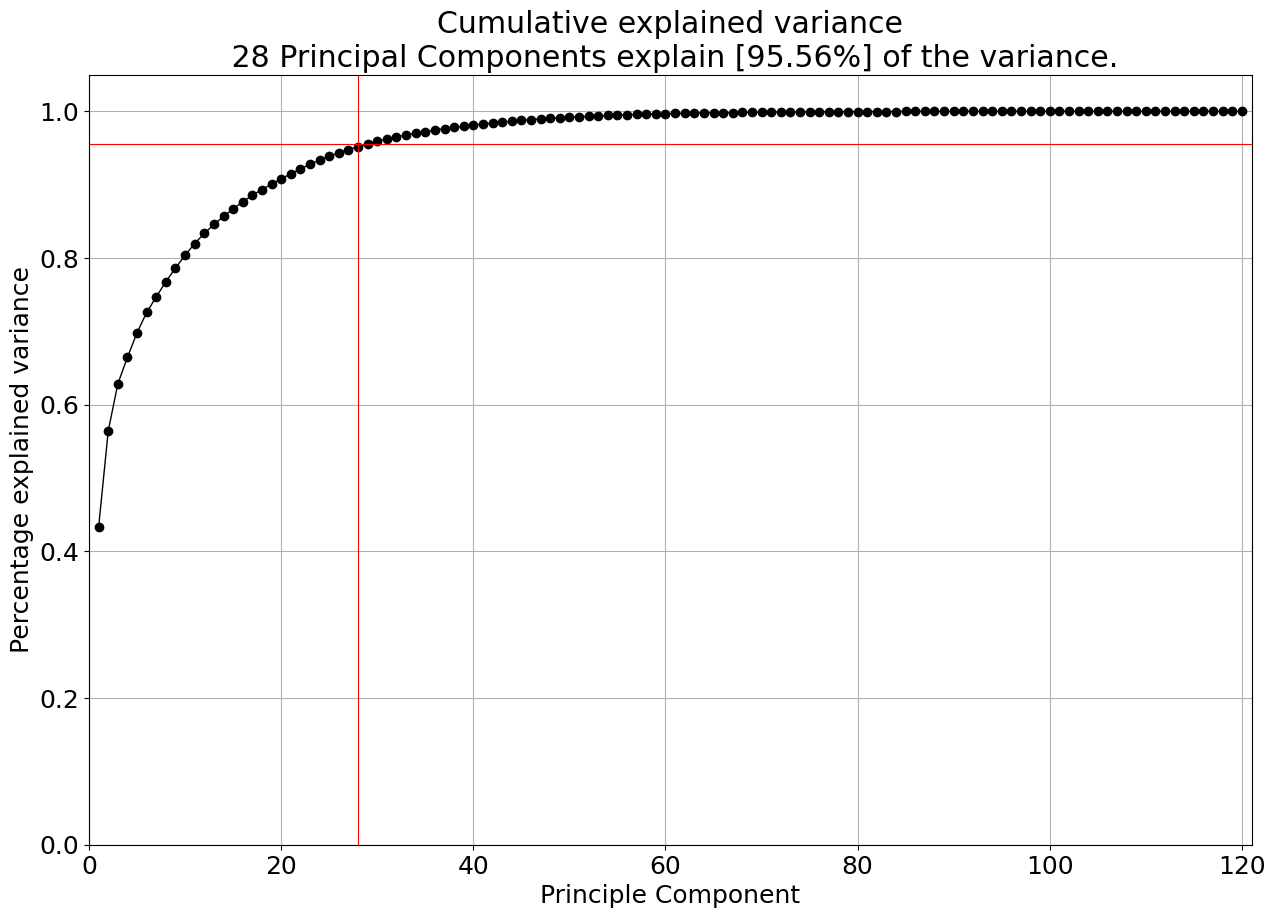

In [146]:
VARIANCE_THRESHOLD = 0.95

# Initialize
pca_model = pca(n_components=VARIANCE_THRESHOLD)
# Fit transform
pca_output = pca_model.fit_transform(X_features_scaled)

# Print the top features. The results show that f1 is best, followed by f2 etc
print(pca_output['topfeat'])
pca_model.plot()

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


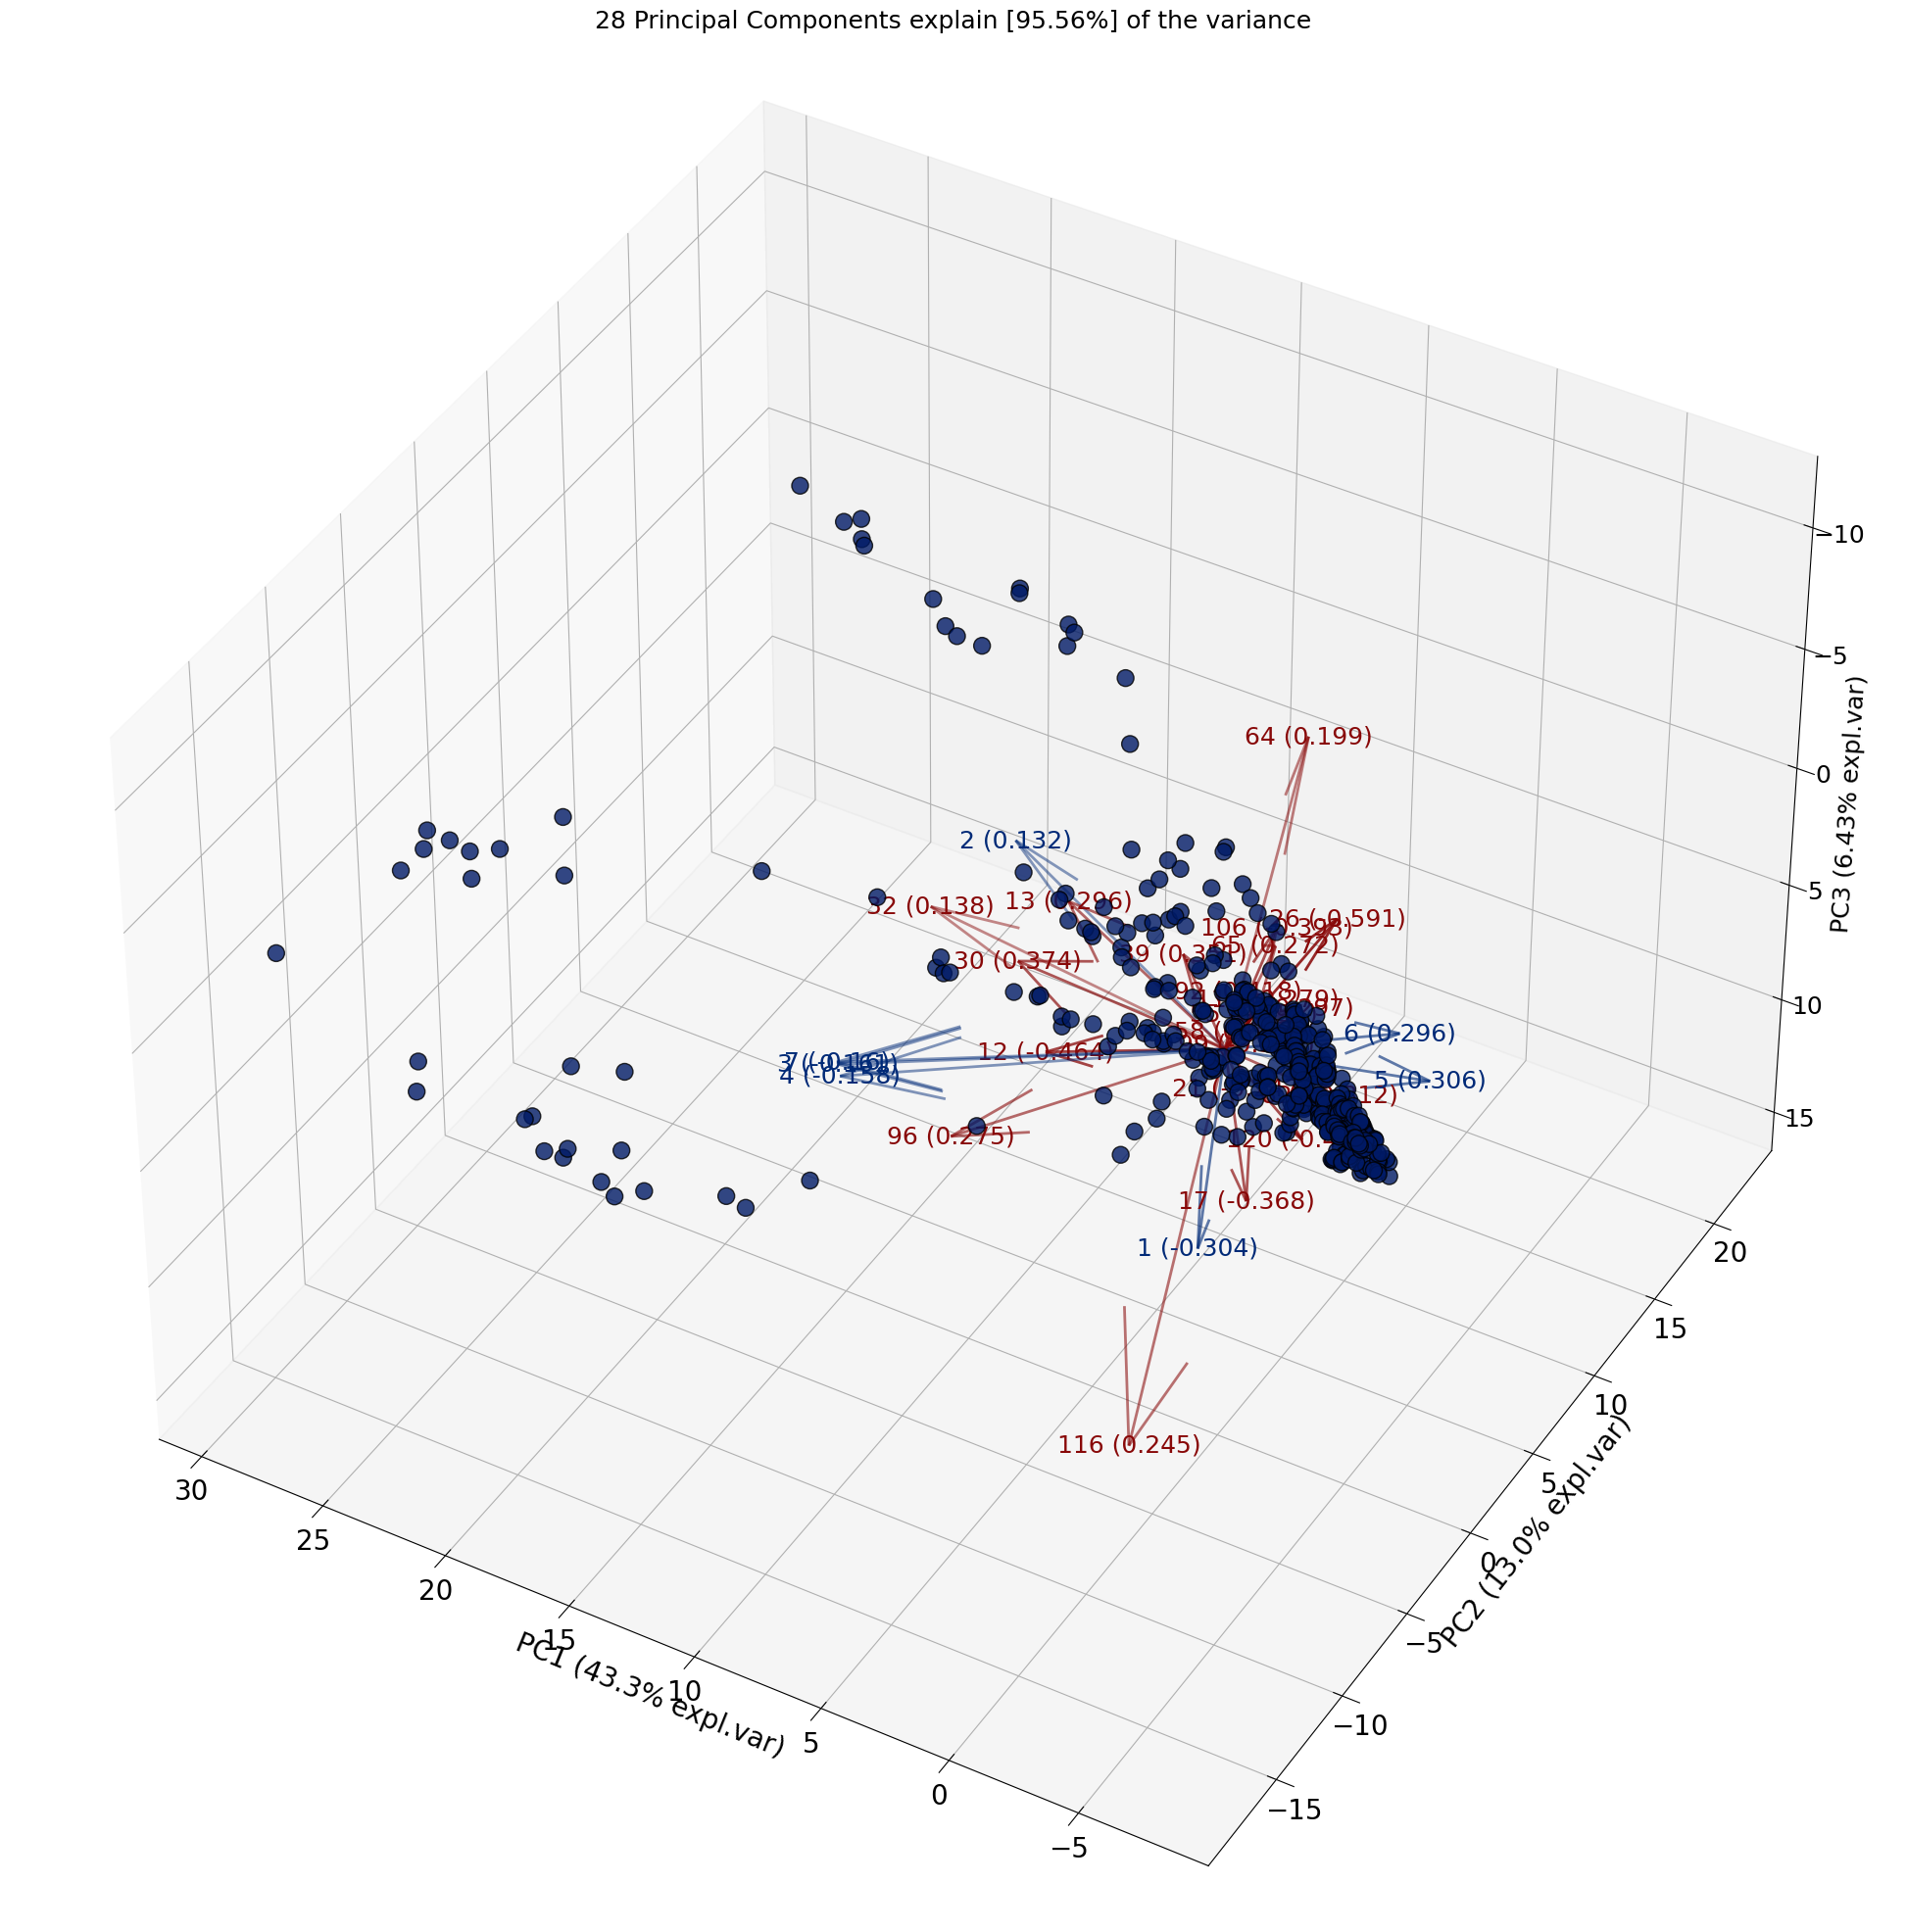

In [147]:
#ax = pca_model.biplot(n_feat=12 , legend=True)

ax = pca_model.biplot3d(n_feat=28, legend=False)


#### Using Skicit Learn libraries for feature seelction and subsequent k-means clustering

In [148]:
  
# Importing PCA 
NUM_COMPONENTS_TO_KEEP = 28

pca_scikit_model = PCA(n_components = NUM_COMPONENTS_TO_KEEP)
pca_scikit_model.fit(X_features_scaled)

X_features_pca = pca_scikit_model.transform(X_features_scaled)

PCA(n_components=28)

In [173]:
X_features_scaled.shape # initial dataframe with ALL features
X_features_pca.shape # PCA selected 28 of them that account for the most variance (Threshhold adjusted in  the first run of non-scikitlearn PCA)

(492, 120)

(492, 28)

In [150]:
pca_scikit_model.components_

array([[ 0.03764553,  0.13213053,  0.09836044, ...,  0.05564048,
         0.08667002, -0.04350619],
       [ 0.05277616,  0.05959586, -0.16050195, ...,  0.00420516,
         0.01812221, -0.01309384],
       [ 0.15654025, -0.01775317, -0.05687479, ...,  0.24140568,
         0.20536251,  0.02069956],
       ...,
       [-0.16965359,  0.00206237,  0.04492961, ...,  0.03786582,
         0.09898583, -0.0103784 ],
       [ 0.1246311 , -0.06079202, -0.02171994, ..., -0.03833461,
         0.12030681,  0.09785386],
       [-0.07394205, -0.03238841,  0.02403281, ...,  0.0441972 ,
        -0.08802177, -0.23299721]])

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'First Principal Component')

Text(0, 0.5, 'Second Principal Component')

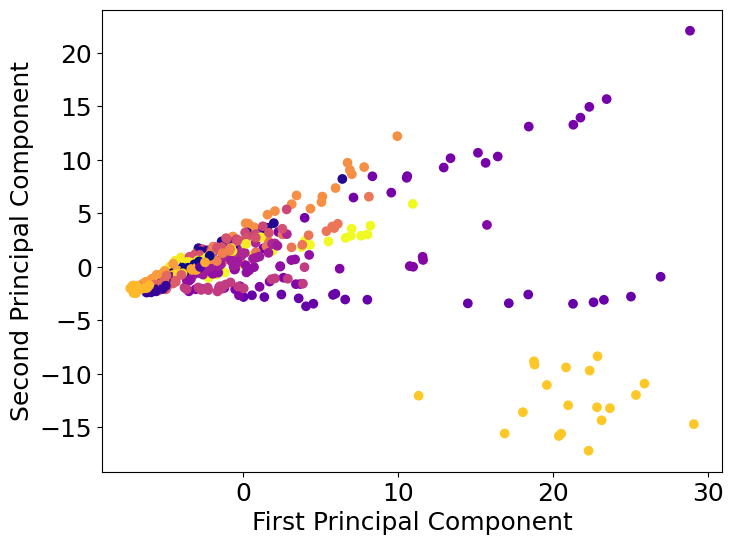

In [151]:
# giving a larger plot
plt.figure(figsize =(8, 6))
  
plt.scatter(X_features_pca[:, 0], X_features_pca[:, 1], c = Y_labels, cmap ='plasma')
  
# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [152]:
pca_scikit_model.components_, pca_scikit_model.explained_variance_ratio_

(array([[ 0.03764553,  0.13213053,  0.09836044, ...,  0.05564048,
          0.08667002, -0.04350619],
        [ 0.05277616,  0.05959586, -0.16050195, ...,  0.00420516,
          0.01812221, -0.01309384],
        [ 0.15654025, -0.01775317, -0.05687479, ...,  0.24140568,
          0.20536251,  0.02069956],
        ...,
        [-0.16965359,  0.00206237,  0.04492961, ...,  0.03786582,
          0.09898583, -0.0103784 ],
        [ 0.1246311 , -0.06079202, -0.02171994, ..., -0.03833461,
          0.12030681,  0.09785386],
        [-0.07394205, -0.03238841,  0.02403281, ...,  0.0441972 ,
         -0.08802177, -0.23299721]]),
 array([0.4334384 , 0.13082872, 0.0643102 , 0.03612386, 0.03362873,
        0.02746333, 0.02138481, 0.02074818, 0.01845331, 0.01753181,
        0.01592057, 0.01379186, 0.01215109, 0.01099522, 0.01020907,
        0.00953079, 0.00921153, 0.00767808, 0.00739998, 0.00708846,
        0.00704939, 0.00650479, 0.00640812, 0.00564487, 0.00523986,
        0.00487339, 0.00425241, 0

In [ ]:
# In order to do so, we run the algorithm with a different number of clusters. 
# Then, we determine the Within Cluster Sum of Squares or WCSS for each solution. Based on the values of the WCSS and an approach known as the Elbow method, 
# we make a decision about how many clusters we’d like to keep.

In [174]:
from sklearn.cluster import KMeans

within_cluster_sum_of_squares = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_features_pca)                # build the clustering model with PCA scores (features)
    within_cluster_sum_of_squares.append(kmeans.inertia_)


KMeans(n_clusters=1, random_state=42)

KMeans(n_clusters=2, random_state=42)

KMeans(n_clusters=3, random_state=42)

KMeans(n_clusters=4, random_state=42)

KMeans(n_clusters=5, random_state=42)

KMeans(n_clusters=6, random_state=42)

KMeans(n_clusters=7, random_state=42)

KMeans(random_state=42)

KMeans(n_clusters=9, random_state=42)

KMeans(n_clusters=10, random_state=42)

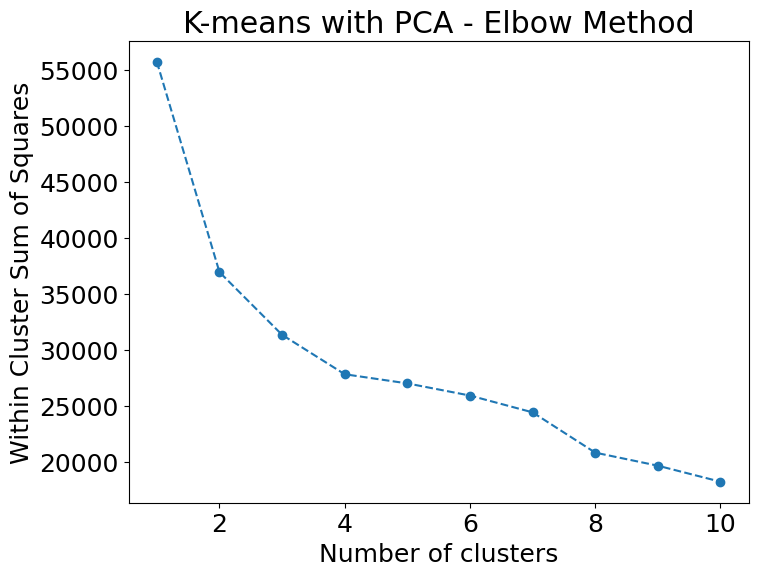

In [215]:
plt.figure(figsize=(8, 6));
plt.plot(range(1, 11), within_cluster_sum_of_squares, marker = 'o', linestyle = '--');
plt.xlabel('Number of clusters');
plt.ylabel('Within Cluster Sum of Squares');
plt.title('K-means with PCA - Elbow Method');
plt.show();

In [248]:
NUM_CLUSTERS = 2

kmeans_pca = KMeans(n_clusters = NUM_CLUSTERS, init = 'k-means++', random_state = 42)
kmeans_pca.fit(X_features_pca)


KMeans(n_clusters=2, random_state=42)

In [ ]:
Random_forest_param_grid = {
    'n_estimators':[100,200],
    'max_features':['sqrt', 'log2'], 
    'max_depth':[100,250,500], 
    'min_samples_split':[2,5], 
    'min_samples_leaf':[1,2], 
    'bootstrap':[True,False],
    'criterion':['gini','entropy']}

rf_grid = GridSearchCV(RandomForestClassifier(), Random_forest_param_grid, verbose = 1)
rf_grid.fit(X_train_route_scaled,y_train_route)
predict_and_create_CM(rf_grid, X_test_route_scaled, y_test_route, display_label=concatenated_route_quarter_tourism['Route of Travel'].unique())


In [249]:
dairy_ag_df_PCA_kmeans = pd.concat([dairy_ag_df_imputed.reset_index(drop=True), pd.DataFrame(X_features_pca)], axis=1)
dairy_ag_df_PCA_kmeans.columns.values[-NUM_COMPONENTS_TO_KEEP:] = ['Component_' + str(i) for i in range(NUM_COMPONENTS_TO_KEEP)] # Add the PCA components to the dataframe
dairy_ag_df_PCA_kmeans['Predicated_Cluster'] = kmeans_pca.labels_

In [250]:
dairy_ag_df_PCA_kmeans.head()

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE

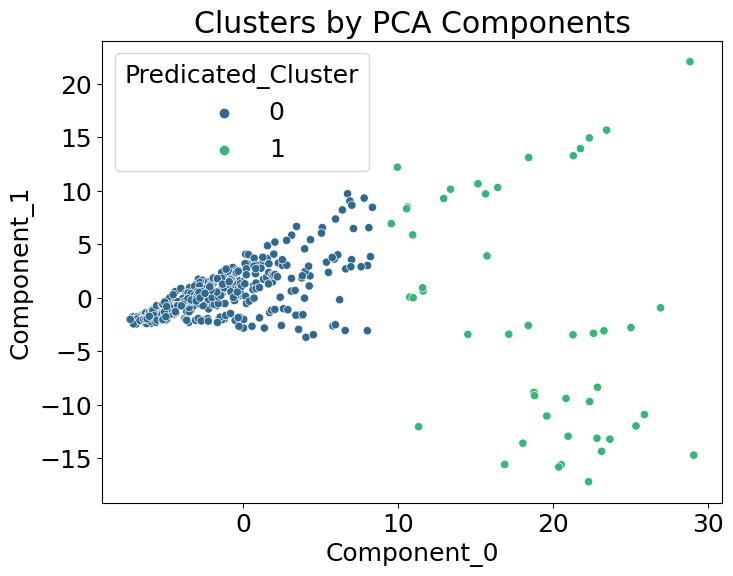

In [251]:
x_axis = dairy_ag_df_PCA_kmeans['Component_0']
y_axis = dairy_ag_df_PCA_kmeans['Component_1']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dairy_ag_df_PCA_kmeans, x=x_axis, y=y_axis, hue=dairy_ag_df_PCA_kmeans['Predicated_Cluster'], palette='viridis')
plt.title('Clusters by PCA Components')
plt.show();

In [252]:
@interact
def show_clusters(cluster=list(range(0, NUM_CLUSTERS)), year=dairy_ag_df_PCA_kmeans['Year'].unique()):
    return dairy_ag_df_PCA_kmeans[(dairy_ag_df_PCA_kmeans['Predicated_Cluster'] == cluster) & (dairy_ag_df_PCA_kmeans.Year == year)][['Member State', "Component_0", "Component_1", "Component_2"]].drop_duplicates().reset_index(drop=True)

interactive(children=(Dropdown(description='cluster', options=(0, 1), value=0), Dropdown(description='year', o…

In [253]:
dairy_ag_df_PCA_kmeans

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE022) Share of OGA work /AWU (%),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)",(SE450) Buildings (€),(SE455) Machinery and equipment (€),(SE460) Breeding livestock (€),(SE465) Total current assets (€),(SE470) Non-breeding livestock (€),(SE475) Stock of agricultural products (€),(SE476) Inventories (€),(SE480) Other circulating capital (€),(SE485) Total liabilities (€),(SE490) Long & medium-term loans (€),(SE495) Short-term loans (€),(SE501) Net worth (€),(SE506) Change in net worth (€),(SE510) Average farm capital (€),(SE516) Gross Investment on fixed assets (€),(SE521) Net Investment on fixed assets (€),(SE526) Cash Flow 1 (€),(SE530) Cash Flow 2 (€),(SE532) Cash flow / farm total capital (€),(SE600) Balance current subsidies & taxes (€),(SE605) Total subsidies - excluding on investments (€),(SE606) Total direct payments (€),(SE611) Compensatory payments/area payments (€),(SE612) Set aside premiums (€),(SE615) Total subsidies on livestock (€),(SE616) Subsidies dairying (€),(SE618) Subsidies sheep & goats (€),(SE621) Environmental subsidies (€),(SE622) LFA subsidies (€),(SE623) Other rural development payments (€),(SE624) Total support for rural development (€),(SE625) Subsidies on intermediate consumption (€),(SE626) Subsidies on external factors (€),(SE630) Decoupled payments (€),(SE631) Single Farm payment (€),(SE632) Single Area payment (€),(SE640) Additional aid (€),(SE650) Support_Art68 (€),(SE699) Other subsidies (€),(SE700) Total OGA output (€/farm),(SE720) Contractual work services (€),(SE725) Agritourism (€),(SE750) Total specific costs for OGA (€),(SE447) Agricultural land (€/farm),(SE462) Intangible assets (€/farm),(SE

In [269]:
import plotly.express as px
from textwrap import wrap

named_colorscales = px.colors.named_colorscales()
print("\n".join(wrap("".join('{:<12}'.format(c) for c in named_colorscales), 96)))

aggrnyl     agsunset    blackbody   bluered     blues       blugrn      bluyl       brwnyl
bugn        bupu        burg        burgyl      cividis     darkmint    electric    emrld
gnbu        greens      greys       hot         inferno     jet         magenta     magma
mint        orrd        oranges     oryel       peach       pinkyl      plasma      plotly3
pubu        pubugn      purd        purp        purples     purpor      rainbow     rdbu
rdpu        redor       reds        sunset      sunsetdark  teal        tealgrn     turbo
viridis     ylgn        ylgnbu      ylorbr      ylorrd      algae       amp         deep
dense       gray        haline      ice         matter      solar       speed       tempo
thermal     turbid      armyrose    brbg        earth       fall        geyser      prgn
piyg        picnic      portland    puor        rdgy        rdylbu      rdylgn      spectral
tealrose    temps       tropic      balance     curl        delta       oxy         edge
hsv     

In [307]:
xmin, xmax = min(dairy_ag_df_PCA_kmeans['(SE085) Dairy cows (LU)']), max(dairy_ag_df_PCA_kmeans['(SE085) Dairy cows (LU)'])
ymin, ymax = min(dairy_ag_df_PCA_kmeans['(SE125) Milk yield (kg/cow)']), max(dairy_ag_df_PCA_kmeans['(SE125) Milk yield (kg/cow)'])

xmax += 0.1 * xmax # same as xmax = xmax + 0.1 * xmax
ymax += 0.1 * ymax


fig = px.scatter(dairy_ag_df_PCA_kmeans[dairy_ag_df_PCA_kmeans.Year <= 2021], x="(SE085) Dairy cows (LU)", y="(SE125) Milk yield (kg/cow)",
                 animation_group="Member State", color="Member State", hover_name="Member State",
                 facet_col="Predicated_Cluster", width=1579, height=400, log_x=False, size_max=45, animation_frame="Year", symbol="Member State",
                 range_x=[xmin,xmax], range_y=[ymin,ymax])
fig.show()

In [313]:
from os import getenv, environ
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime as dt
import praw

from praw.models import MoreComments
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [318]:
load_dotenv()

APP_NAME = getenv("APP_NAME")
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
REDDIT_NAME = getenv("REDDIT_NAME")

False

In [319]:
reddit = praw.Reddit(
    client_id = APP_ID,
    client_secret = APP_SECRET,
    user_agent = f"{APP_NAME} u/{REDDIT_NAME}"
)
print(reddit.read_only)

True


In [337]:
SUBREDDIT_TITLE = "farming"
SUBREDDIT_POST_LIMIT = 50

subreddit = reddit.subreddit(SUBREDDIT_TITLE)
new_posts = {}
for post in subreddit.new(limit=SUBREDDIT_POST_LIMIT):
    new_posts[post.id] = post.title

new_posts
 

{'1cqgm3o': 'Recommendations for a chain/drag harrow? ',
 '1cqg4km': 'Spontaneous Combustion',
 '1cqdm5u': 'growing hydroponic grass ',
 '1cqd0cg': 'Help with Covington planter.',
 '1cqcpnj': 'Where to order a used rock picker for reasonable delivery?',
 '1cqc5jw': 'The strips are there somewhere...',
 '1cq9tle': 'Beginner help ',
 '1cq9j66': 'How to encourage older farmers to retire?',
 '1cq9j0h': 'How to encourage older farmers to retire?',
 '1cq9b4w': 'Grains: What are the Next Seasonal Moves?',
 '1cq992p': 'Can I Feed My Cows Green Wheat? ',
 '1cq7fav': 'Best state for Apple trees?',
 '1cq6pzh': 'Looking at buying this tractor for 4 acres, Summit tractor',
 '1cq69rp': 'Grazing livestock on cropland pays off',
 '1cq39da': 'Anyone work extremely hilly ground ?',
 '1cq2j4l': 'Do farmers move to restart farming elsewhere after real estate tycoons chase them out of start building cities over farmland?',
 '1cq194z': 'Help! Taming a small but overgrown orchard',
 '1cq12yq': 'Farmer walkin

In [340]:
def get_all_comments(comment, level, post_id, post_title):
    try:
        comments.append([
            post_id,
            post_title,
            level,
            comment.body,
            comment.likes,
            comment.score,
            comment.subreddit,
        ])
    except Exception as e:
        print(e)

    try:
        if comment.replies:
            for reply in comment.replies:
                get_all_comments(reply, level + 1, post_id, post_title)
    except Exception as e:
        print(e)

comments = []
for post_id, post_title in new_posts.items():
    submission = reddit.submission(post_id)
    print('Post ID ', post_id, 'contains ', submission.num_comments, ' comments') # Will be used to validate the resulting dataframes and identify if some comments have been missed

    if submission.num_comments < 20:
        print('Post has less then 20 comments, move on to the next post')
        continue
    
    print('Post has over 20 comments, proceeding to gathering comments...')
    for comment in submission.comments:        
        get_all_comments(comment, level=0, post_id=post_id, post_title=post_title)


comments_pd = pd.DataFrame(comments, columns=[
        'post_id',
        'post_title',
        'comment_level',
        'comment_body',
        'comment_likes',
        'comment_score',
        'comment_subreddit',
])
comments_pd.to_csv(f"reddit/crawled_posts.csv", index=False)


Post ID  1cqgm3o contains  1  comments
Post has less then 20 comments, move on to the next post
Post ID  1cqg4km contains  1  comments
Post has less then 20 comments, move on to the next post
Post ID  1cqdm5u contains  0  comments
Post has less then 20 comments, move on to the next post
Post ID  1cqd0cg contains  2  comments
Post has less then 20 comments, move on to the next post
Post ID  1cqcpnj contains  8  comments
Post has less then 20 comments, move on to the next post
Post ID  1cqc5jw contains  1  comments
Post has less then 20 comments, move on to the next post
Post ID  1cq9tle contains  1  comments
Post has less then 20 comments, move on to the next post
Post ID  1cq9j66 contains  93  comments
Post has over 20 comments, proceeding to gathering comments...
Post ID  1cq9j0h contains  12  comments
Post has less then 20 comments, move on to the next post
Post ID  1cq9b4w contains  0  comments
Post has less then 20 comments, move on to the next post
Post ID  1cq992p contains  3  co

In [341]:
reddit_data_df = pd.read_csv('reddit/crawled_posts.csv')
reddit_data_df

,post_id,post_title,comment_level,comment_body,comment_likes,comment_score,comment_subreddit
0,1cq9j66,How to encourage older farmers to retire?,0,They would likely rather die on the farm than ...,NaN,133,farming
1,1cq9j66,How to encourage older farmers to retire?,1,Solid insight.,NaN,20,farming
2,1cq9j66,How to encourage older farmers to retire?,1,My dad 82 is the same way. He has 460 acres. R...,NaN,19,farming
3,1cq9j66,How to encourage older farmers to retire?,2,I have to ride mine side saddle most of the ti...,NaN,7,farming
4,1cq9j66,How to encourage older farmers to retire?,2,I dunno why reddit sent me here but is side sa...,NaN,1,farming
...,...,...,...,...,...,...,...
931,1co9smm,Life after Dairy…,0,If no one is interested in continuing with dai...,NaN,1,farming
932,1co9smm,Life after Dairy…,1,Yeah… Beef might be the plan but for now I’m f...,NaN,2,farming
933,1co9smm,Life after Dairy…,0,We sold out our cows when I was a sophomore in...,NaN,1,farming
934,1co9smm,Life after Dairy…,0,Because of the fact that you are asking for in...,NaN,-9,farming
